第一个因子：Alpha7

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [103]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20160601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

12.20634150505066


In [104]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [105]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [106]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [107]:
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [108]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')
close= dv.get_ts('close', date_type='datetime')

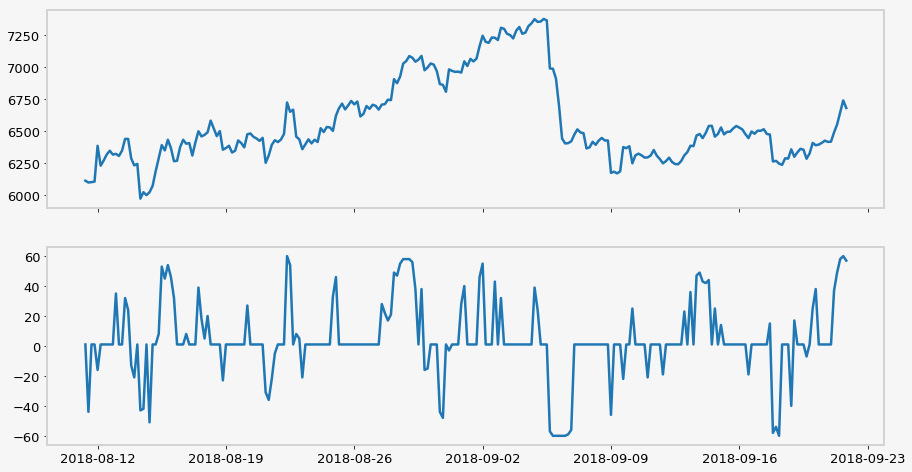

In [109]:
plot_chart(close, alpha7_plot)

In [118]:
# 进场信号
long = dv.add_formula('longAlpha7','If(Sma(close-Delay(close,5),5,1)<=0.005 ,2,0)', add_data=True)
short = dv.add_formula("shortAlpha7","If(Sma(close-Delay(close,5),5,1)>0.005 ,-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha7","If(shortAlpha7==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha7","If(longAlpha7==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha7','shortAlpha7','closeLongAlpha7','closeShortAlpha74', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")

Field [longAlpha7] is overwritten.
Field [shortAlpha7] is overwritten.
Field [closeLongAlpha7] is overwritten.
Field [closeShortAlpha7] is overwritten.
Nan Data Count (should be zero) : 0;  Percentage of effective data: 49%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 48%
*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               25.226  -61.469     4.233
p-value               0.000    0.000     0.000
mean                  0.099   -0.057     0.011
std                   0.101    0.027     0.104
info_ratio            0.975   -2.090     0.108
skewness              1.007    0.229     1.482
kurtosis             -0.273    0.188     1.611
pct5                  0.003   -0.101    -0.091
pct25                 0.018   -0.071    -0.059
pct50                 0.055   -0.058    -0.014
pct75                 0.148   -0.052     0.038
pct95                 0.312   -0.004     0.261
occurance           671.000  866.000  1537.000
win_ratio  

【【总结1】】
1. Alpha7因子:  ((adv20 < volume) ? ((-1 ts_rank(abs(delta(close, 7)), 60)) sign(delta(close, 7))) : (-1* 1))
2. 代入代码：alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume,(-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)
3. 规律：
（1）alpha7数值小于0，对应close基本下降，反之则上升。
（2）alpha7的数值涨跌与收盘价相似，且会放大收盘价斜率的绝对值激增的情况，弱化波动较小的收盘价变化。

【收盘价与alpha7波动关系】
同向变动，收盘价变化率较大时alpha7图像放大其变动，收盘价波动较少时alpha7横向不变。（详细见上规律）

【信号与进出场条件设置】
进场：
long = dv.add_formula('longAlpha7','If(Sma(close-Delay(close,5),5,1)<=0.005 ,2,0)', add_data=True)
short = dv.add_formula("shortAlpha7","If(Sma(close-Delay(close,5),5,1)>0.005 ,-2,0)", add_data=True)
出场：
close_long = dv.add_formula("closeLongAlpha7","If(shortAlpha7==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha7","If(longAlpha7==2,-1,0)", add_data=True)

第二个因子：MACD

In [64]:
#----------------------------------------------------------------------------------------------------------------------------------#

Initialize dataview success.


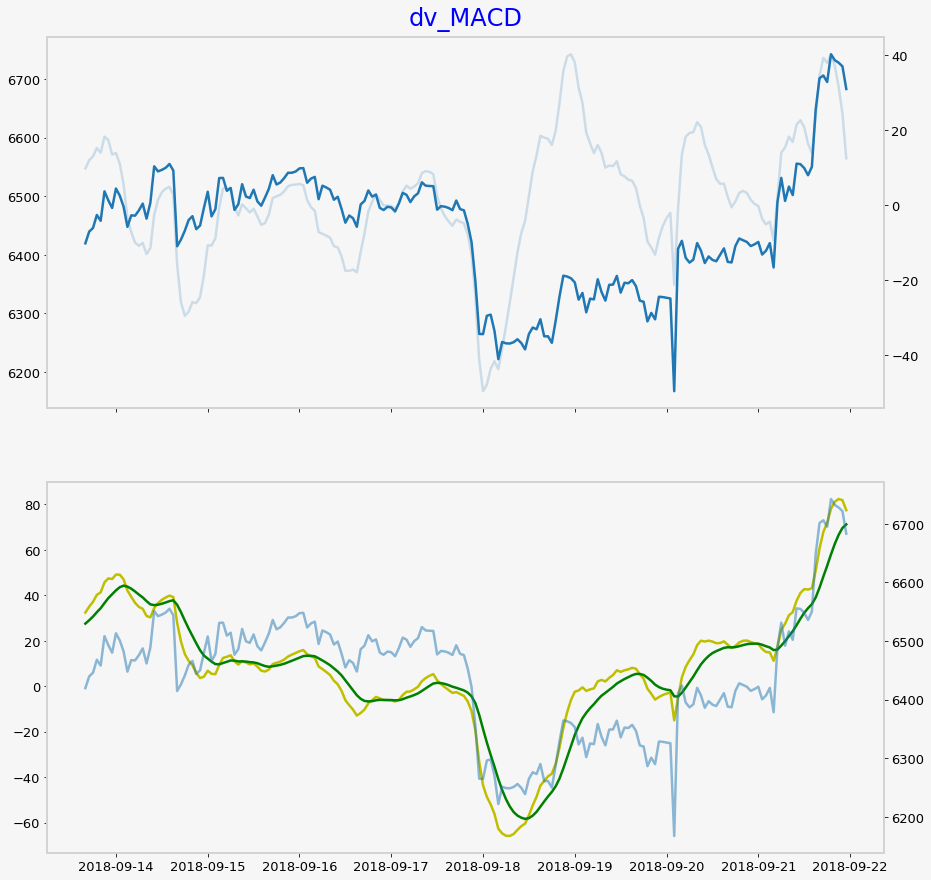

In [114]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) 

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, MACD, Diff, Dea, chart_name='dv_MACD', n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(MACD.iloc[n:], alpha=0.2)
    ax1.plot(Diff.iloc[n:], alpha=1,color='y')
    ax1.plot(Dea.iloc[n:], alpha=1,color='g')
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('Diff_J',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)", add_data=True)
dv1H.add_formula('Dea_J',"Ta('EMA',0,0,0,0,Diff_J,0,9)", add_data=True)
dv1H.add_formula('MACD_J',"(Diff_J-Dea_J)*2",add_data=True).tail(10)

MACD = dv1H.get_ts('MACD_J', date_type='datetime')
Diff = dv1H.get_ts('Diff_J', date_type='datetime')
Dea = dv1H.get_ts('Dea_J', date_type='datetime')

Plot_Mean(dv1H, MACD.iloc[:,0], Diff.iloc[:,0], Dea.iloc[:,0], n=-200)

【【总结2】】
1. 技术指标MACD ：利用收盘价的短期（常用为12日）指数移动平均线与长期（常用为26日）指数移动平均线之间的聚合与分离状况，对买进、卖出时机作出研判的技术指标。
2. 带入代码：Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26),Dea_J=Ta('EMA',0,0,0,0,Diff_J,0,9),MACD_J=(Diff_J-Dea_J)*2
3. 规律：相对于收盘价变化，有一定的滞后性。基本符合收盘价变化规律。

【收盘价与MACD关系】
1. 
EMA（12）=前一日EMA（12）×11/13+今日收盘价×2/13
EMA（26）=前一日EMA（26）×25/27+今日收盘价×2/27
2. DIF=今日EMA（12）－今日EMA（26）
3. 今日DEA（MACD）=前一日DEA×8/10+今日DIF×2/10。用（DIF-DEA）×2即为MACD柱状图。

【信号与进出场条件】
1. DIF、DEA均为正，DIF向上突破DEA，买入。
2. DIF、DEA均为负，DIF向下跌破DEA，卖出。
3. DIF线与K线发生背离，行情可能出现反转信号。
4. DIF、DEA的值从正数变成负数，或者从负数变成正数并不是交易信号，有一定滞后性。